# More sophisticated Neural Network for RUL Prediction

## Introduction

This notebook focuses on designing and implementing neural network models for predicting the Remaining Useful Life (RUL) of engines using the NASA CMAPSS dataset and a more complex model. The dataset provides multivariate time-series data capturing engine operational and sensor measurements. By analyzing these sequences, we aim to estimate the RUL, which is critical for predictive maintenance and avoiding unexpected failures.

In this notebook we are going to NOT use the **engineered** features.

### Objectives
1. **Develop a Baseline Model:** (Done)
   - Implement a baseline neural network using **RNN** layers to leverage the sequential nature of the data.
   - Evaluate the baseline model's performance as a benchmark.

2. **Experiment with more complex models like GRU and Transformer-Based Models:**
   - Implement a more advanced architecture based on transformers for sequence modeling and feature extraction.
   - Compare its performance with the LSTM-based baseline model.

### Plan
1. **Prepare the Data:**
   - Use the preprocessed and scaled dataset created in previous notebooks.
   - Ensure the dataset supports both original features and optional engineered features for flexibility in experimentation.

2. **Baseline Model (LSTM):**
   - Use LSTM layers to capture temporal dependencies in the sequence data.
   - Evaluate the model's performance using Mean Squared Error (MSE) as the loss metric.

3. **Transformer-Based Model:**
   - Design a transformer architecture for sequence-to-sequence modeling.
   - Focus on capturing long-range dependencies and complex interactions among features.

4. **Model Comparison and Evaluation:**
   - Compare the models on key metrics such as Mean Absolute Error (MAE) and MSE.
   - Analyze the advantages and trade-offs of each approach.

### Why Use LSTMs and Transformers?
- **LSTMs:** 
  - Effective at capturing temporal dependencies and patterns in sequential data.
  - Provide a strong benchmark for sequence modeling tasks.
- **Transformers:**
  - Offer enhanced capability to model long-range dependencies compared to LSTMs.
  - Utilize attention mechanisms to focus on the most relevant parts of the sequence.

### Expected Outcome
By the end of this notebook, we aim to:
- Establish a strong baseline model for RUL prediction.
- Explore the potential of transformer-based models for handling sequence data.
- Gain insights into the strengths and limitations of these architectures for predictive maintenance tasks.

Let's begin by loading the prepared dataset and setting up the baseline model.


# Preparing our existing CMAPSSDataset for a sequence based network
For that see the code in v3/dataset.py.

In [1]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from codebase.v4.dataset import CMAPSSDataset, SequenceCMAPSSDataset

# Define a function to prepare the DataLoader
def prepare_sequence_dataloader(
        data_dir, data_index, feature_cols, batch_size=32, 
        mode="train", compute_engineered_features=True, sequence_length=30, overlap=20):
    """
    Prepares the DataLoader for the CMAPSS dataset.
    
    Args:
        data_dir (str): Directory containing the dataset files.
        data_index (int): Index of the dataset file to load (0 to 3).
        feature_cols (list): List of feature columns to use.
        batch_size (int): Batch size for the DataLoader.
        mode (str): Mode of the dataset, "train" or "test".
        compute_engineered_features (bool): Whether to include engineered features.
        
    Returns:
        DataLoader: PyTorch DataLoader for the CMAPSS dataset.
    """
    # Initialize the dataset
    dataset = CMAPSSDataset(
        data_dir=data_dir,
        data_index=data_index,
        feature_cols=feature_cols,
        mode=mode,
        compute_engineered_features=compute_engineered_features,
        features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"]
    )
    
    # Wrap it with the sequence-based dataset
    sequence_dataset = SequenceCMAPSSDataset(
        dataset=dataset, sequence_length=sequence_length, overlap=overlap)

    # Create DataLoader
    dataloader = DataLoader(sequence_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    return dataloader


In [2]:
def test_sequence_dataset(dataloader, mode="train"):
    """
    Test the SequenceCMAPSSDataset and display an example output.

    Args:
        dataset (CMAPSSDataset): The original CMAPSSDataset instance.
        sequence_length (int): Length of each sequence.
        batch_size (int): Batch size for the DataLoader.
    """
    
    # Fetch one batch
    for batch_idx, batch in enumerate(dataloader):
        if mode == "train":
            sequences, targets, engine_ids, _ = batch
            print(f"Batch {batch_idx + 1}")
            print(f"Sequences Shape: {sequences.shape}")  # Expected: (batch_size, sequence_length, num_features)
            print(f"Targets Shape: {targets.shape}")  # Expected: (batch_size,)
            print(f"Sample Sequence (First in Batch):\n{sequences[0]}")
            print(f"Corresponding Target (First in Batch):\n{targets[0]}")
            print(f"Engine ID (First in batch): {engine_ids[0]}")
        else:
            sequences, engine_ids, engine_ids = batch
            print(f"Batch {batch_idx + 1}")
            print(f"Sequences Shape: {sequences.shape}")  # Expected: (batch_size, sequence_length, num_features)
            print(f"Sample Sequence (First in Batch):\n{sequences[0]}")
            print(f"Engine ID (First in batch): {engine_ids[0]}")
        break  # Only fetch the first batch for demonstration


In [2]:
import pandas as pd

# Set up paths and features
data_dir = "data/CMAPSSData"
data_index = 1  # Choose FD001, FD002, etc.

compute_engineered_features = True # deactivated for this notebook
sequence_length = 30
batch_size = 512
overlap = 10

train_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
train_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

constant_cols = train_data[feature_cols].nunique()
constant_cols = constant_cols[constant_cols == 1]

feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

# Prepare DataLoader
# sequence_train_loader = prepare_sequence_dataloader(
#     data_dir=data_dir, data_index=data_index, feature_cols=feature_cols, 
#     batch_size=batch_size, mode="train", sequence_length=sequence_length, overlap=overlap,
#     compute_engineered_features=compute_engineered_features)

# # Test the sequence dataset
# test_sequence_dataset(sequence_train_loader, mode="train")

## The code for the grouped k-fold approach:
See explanations in previous notebook.

In [3]:
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader

# Function to implement Group k-Fold with your custom dataset
def prepare_kfold_cross_validation_loaders(original_dataset, sequence_length, overlap, n_splits=5, batch_size=32):
    """
    Implements Group k-Fold Cross-Validation for the CMAPSS dataset.
    
    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        sequence_length (int): Length of each sequence.
        overlap (int): Overlap between sequences.
        n_splits (int): Number of folds for cross-validation.
        batch_size (int): Batch size for the DataLoader.
    
    Returns:
        List[Tuple[DataLoader, DataLoader]]: Training and validation DataLoaders for each fold.
    """
    # Extract engine IDs and features for grouping
    engine_ids = original_dataset.data['engine_id'].values
    features = original_dataset.data[original_dataset.feature_cols].values
    targets = original_dataset.data['RUL'].values

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=n_splits)

    fold_loaders = []  # Store DataLoaders for each fold

    # Perform Group k-Fold split (features and targets are not directly used for the split)
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(features, targets, groups=engine_ids)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        # Create train and validation datasets
        train_data = original_dataset.data.iloc[train_idx]
        val_data = original_dataset.data.iloc[val_idx]

        train_dataset = SequenceCMAPSSDataset(
            dataset=CMAPSSDatasetSubset(train_data, original_dataset.feature_cols, mode="train"),
            sequence_length=sequence_length,
            overlap=overlap
        )

        val_dataset = SequenceCMAPSSDataset(
            dataset=CMAPSSDatasetSubset(val_data, original_dataset.feature_cols, mode="train"),
            sequence_length=sequence_length,
            overlap=overlap
        )

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

        fold_loaders.append((train_loader, val_loader))
    
    return fold_loaders

# Helper class to create a subset of the CMAPSSDataset
class CMAPSSDatasetSubset(CMAPSSDataset):
    def __init__(self, data_subset, feature_cols, mode):
        """
        Creates a subset of the CMAPSSDataset using the provided data.

        Args:
            data_subset (pd.DataFrame): Subset of the original dataset.
            feature_cols (list): List of feature columns to include.
            mode (str): Mode of the dataset, "train" or "test".
        """
        self.data = data_subset
        self.feature_cols = feature_cols
        self.mode = mode


In [4]:
# Initialize the dataset
dataset = CMAPSSDataset(
    data_dir=data_dir,
    data_index=data_index,
    feature_cols=feature_cols,
    mode="train",
    compute_engineered_features=compute_engineered_features,
    features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"]
)

# Perform Group k-Fold Cross-Validation
sequence_length = sequence_length
overlap = 10 # see explanation below
n_splits = 5
batch_size = batch_size

# 2. Perform Group k-Fold Cross-Validation
fold_loaders = prepare_kfold_cross_validation_loaders(
    original_dataset=dataset,
    sequence_length=sequence_length,
    overlap=overlap,
    n_splits=n_splits,
    batch_size=batch_size
)

# Access the DataLoaders for each fold
for fold, (train_loader, val_loader) in enumerate(fold_loaders):
    print(f"Fold {fold + 1}")
    
    # Training DataLoader
    print(f"  Number of training sequences: {len(train_loader.dataset)}")
    first_train_item = next(iter(train_loader))
    train_features, train_targets, train_engine_ids, cycles = first_train_item
    print(f"  Training Features Shape: {train_features.shape}")
    print(f"  Training Targets Shape: {train_targets.shape}")
    print(f"  First Training Item (Features):\n{train_features[0]}")
    print(f"  First Training Item (Target): {train_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")
    
    # Validation DataLoader
    print(f"  Number of validation sequences: {len(val_loader.dataset)}")
    first_val_item = next(iter(val_loader))
    val_features, val_targets, train_engine_ids, cycles = first_val_item
    print(f"  Validation Features Shape: {val_features.shape}")
    print(f"  Validation Targets Shape: {val_targets.shape}")
    print(f"  First Validation Item (Features):\n{val_features[0]}")
    print(f"  First Validation Item (Target): {val_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")

    break  # Only display the first fold for demonstration


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Fold 1
  Number of training sequences: 735
  Training Features Shape: torch.Size([512, 30, 38])
  Training Targets Shape: torch.Size([512])
  First Training Item (Features):
tensor([[ 0.2325,  1.3565, -1.9116,  ...,  1.6639, -0.9466, -0.9128],
        [-0.4528,  1.3565, -2.7708,  ...,  1.5951, -0.9704,  0.0604],
        [ 0.0498, -0.6919, -1.3121,  ...,  1.7334, -1.0457,  0.5441],
        ...,
        [ 0.5979, -0.3505, -2.2113,  ...,  1.3599, -1.9710, -0.1556],
        [-1.4578,  1.3565, -1.7917,  ...,  1.3684, -1.9023,  0.5206],
        [ 1.9228,  1.0151, -1.1323,  ...,  1.4387, -1.5224,  0.1790]])
  First Training Item (Target): 253.0
  Engine ID (First in batch): 2
  Cycles (For first sequence in batch): tensor([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], dtype=torch.int32)
  Number of validation sequences: 183
  Validation Features Shape: torch.Size([18

## Validate the grouped k-fold loaders

In [6]:
import torch

def validate_kfold_loaders(original_dataset, fold_loaders, sequence_length):
    """
    Validates the integrity of k-fold DataLoaders against the original dataset.

    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
        sequence_length (int): Number of time steps in each sequence.
        overlap (int): Overlap between consecutive sequences.

    Returns:
        bool: True if all validations pass, otherwise raises an AssertionError.
    """
    original_data = original_dataset.data
    used_indices = set()  # Track all rows covered across folds

    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Validating Fold {fold + 1}")
        
        # Get engine IDs for train and validation sets
        train_engines = set(train_loader.dataset.dataset.data['engine_id'])
        val_engines = set(val_loader.dataset.dataset.data['engine_id'])
        
        # Check group exclusivity
        assert train_engines.isdisjoint(val_engines), \
            f"Fold {fold + 1}: Train and validation sets share engine IDs: {train_engines & val_engines}"

        # Validate training data
        for features, targets, engine_ids, cycles in train_loader:
            for idx, (seq, target, engine_id) in enumerate(zip(features, targets, engine_ids)):
                cycle_start = int(cycles[idx, 0].item())  # Convert cycle_start to an integer

                # Check sequence correctness
                for t, cycle in enumerate(range(cycle_start, cycle_start + sequence_length)):
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) &
                        (original_data['cycle'] == float(cycle))
                    ]
                    assert not original_row.empty, \
                        f"Missing data for engine {engine_id}, cycle {cycle} in training set"

                    # Verify feature values
                    original_features = original_row.iloc[0, 2:-1].values  # Features are columns 2 to -1
                    assert torch.allclose(seq[t, 0:], torch.tensor(original_features, dtype=torch.float32)), \
                        f"Mismatch in features for engine {engine_id}, cycle {cycle}"

                # Verify RUL target
                last_cycle = cycle_start + sequence_length - 1
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == float(last_cycle))
                ]['RUL'].iloc[0]
                assert torch.isclose(target, torch.tensor(expected_rul, dtype=torch.float32)), \
                    f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"


        # Validate validation data (similar to training data)
        for features, targets, engine_ids, cycles in val_loader:
            for idx, (seq, target, engine_id) in enumerate(zip(features, targets, engine_ids)):                
                cycle_start = int(cycles[idx, 0].item())  # Convert cycle_start to an integer

                for t, cycle in enumerate(range(cycle_start, cycle_start + sequence_length)):
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) &
                        (original_data['cycle'] == float(cycle))
                    ]
                    assert not original_row.empty, \
                        f"Missing data for engine {engine_id}, cycle {cycle} in validation set"

                    original_features = original_row.iloc[0, 2:-1].values
                    assert torch.allclose(seq[t, 0:], torch.tensor(original_features, dtype=torch.float32)), \
                        f"Mismatch in features for engine {engine_id}, cycle {cycle}"

                last_cycle = cycle_start + sequence_length - 1
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == float(last_cycle))
                ]['RUL'].iloc[0]
                assert torch.isclose(target, torch.tensor(expected_rul, dtype=torch.float32)), \
                    f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"

        # Track all covered indices
        train_indices = train_loader.dataset.dataset.data.index
        val_indices = val_loader.dataset.dataset.data.index
        used_indices.update(train_indices)
        used_indices.update(val_indices)

    # Check overall coverage
    assert len(used_indices) == len(original_data), \
        "Not all rows in the original dataset are covered by the k-fold loaders"

    print("All validations passed!")
    return True

validate_kfold_loaders(dataset, fold_loaders, sequence_length=sequence_length)

Validating Fold 1


Validating Fold 2
Validating Fold 3
Validating Fold 4
Validating Fold 5
All validations passed!


True

## Inspect characteristics of each fold (to ensure they are homogenic)

Inspecting Fold 1
  Training RUL Statistics:
count    1423.000000
mean       94.162331
std        61.448547
min         0.000000
25%        44.000000
50%        89.000000
75%       135.000000
max       307.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    355.000000
mean      95.180283
std       64.353195
min        0.000000
25%       44.500000
50%       88.000000
75%      136.000000
max      328.000000
Name: RUL, dtype: float64


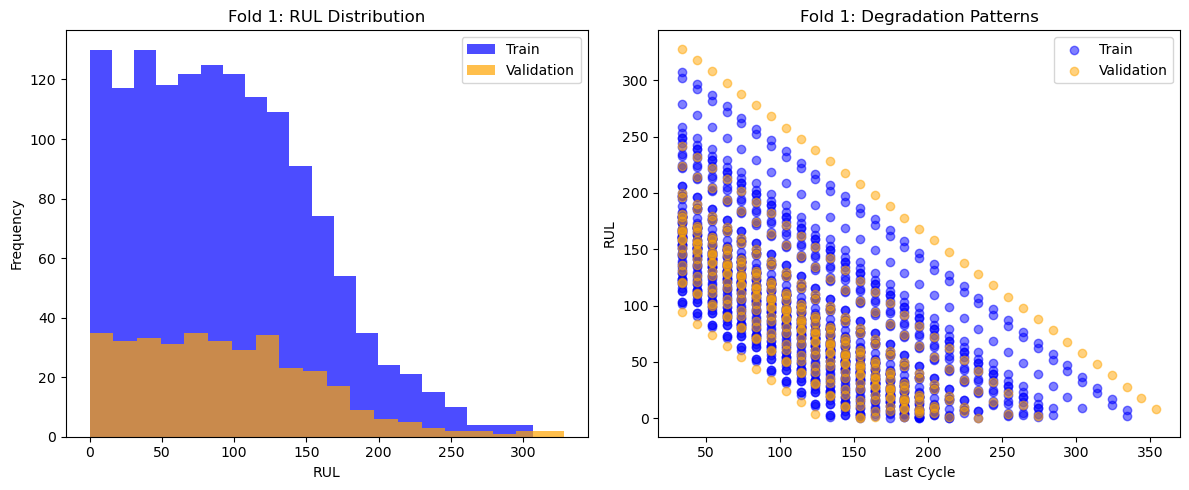

Inspecting Fold 2
  Training RUL Statistics:
count    1422.000000
mean       94.284813
std        61.922920
min         0.000000
25%        44.000000
50%        89.000000
75%       135.000000
max       328.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    356.000000
mean      94.688202
std       62.504139
min        1.000000
25%       44.000000
50%       88.000000
75%      135.250000
max      307.000000
Name: RUL, dtype: float64


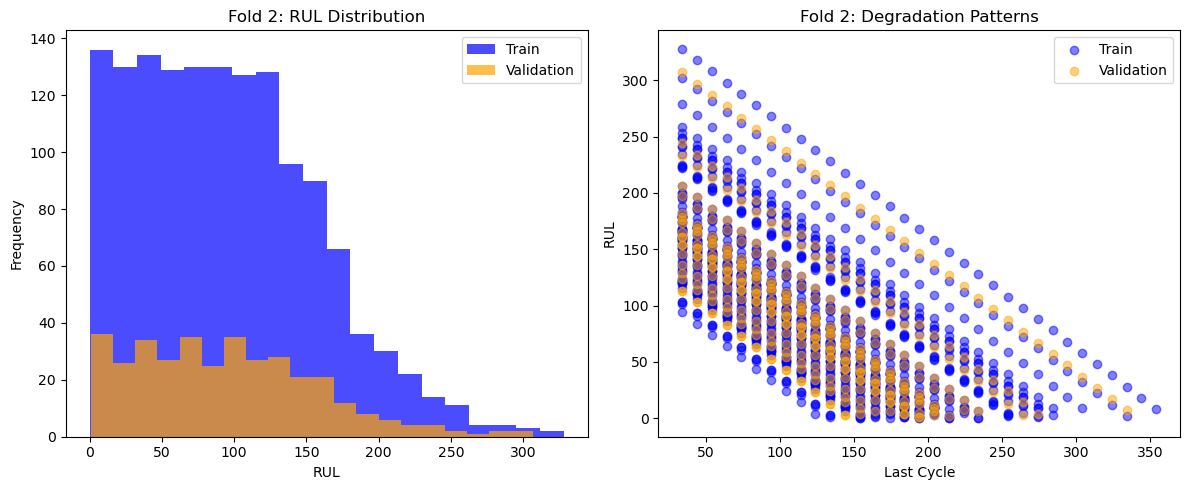

Inspecting Fold 3
  Training RUL Statistics:
count    1424.000000
mean       94.254211
std        62.049610
min         0.000000
25%        44.000000
50%        89.000000
75%       135.000000
max       328.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    354.000000
mean      94.813560
std       61.997784
min        0.000000
25%       45.250000
50%       89.000000
75%      136.000000
max      302.000000
Name: RUL, dtype: float64


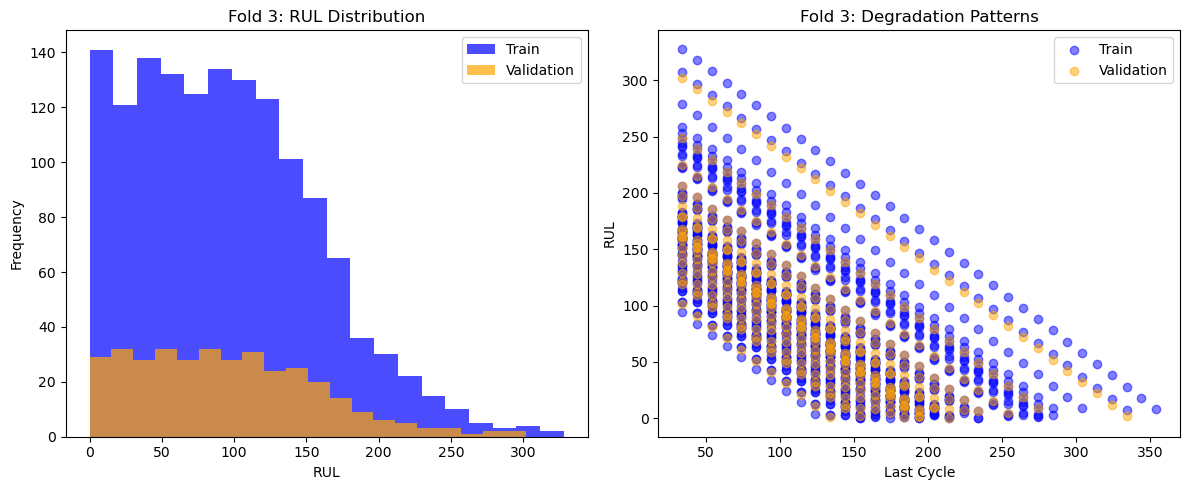

Inspecting Fold 4
  Training RUL Statistics:
count    1422.000000
mean       94.504921
std        62.281769
min         0.000000
25%        44.000000
50%        89.000000
75%       135.750000
max       328.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    356.000000
mean      93.808990
std       61.058067
min        0.000000
25%       43.000000
50%       89.000000
75%      135.000000
max      279.000000
Name: RUL, dtype: float64


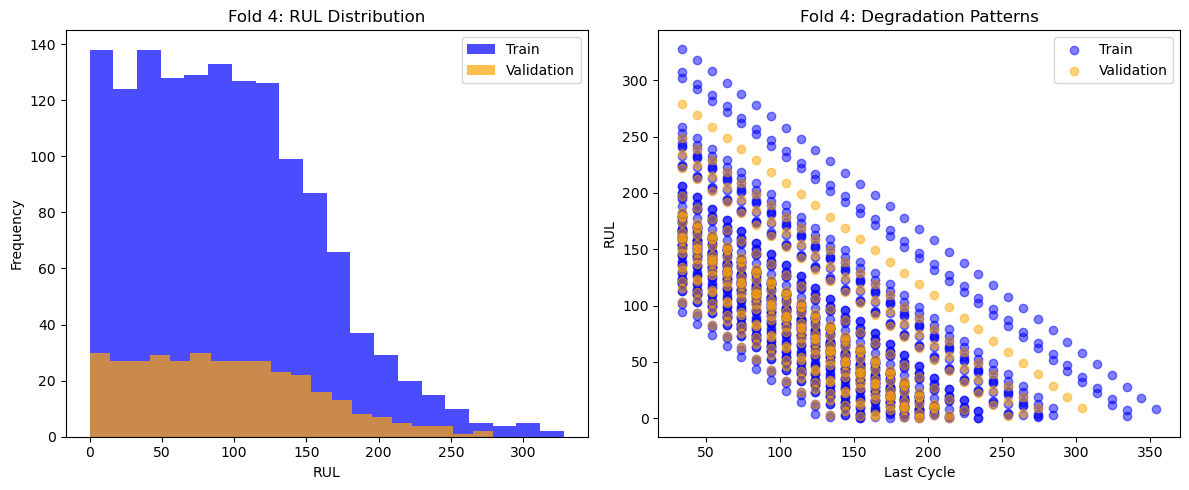

Inspecting Fold 5
  Training RUL Statistics:
count    1421.000000
mean       94.622101
std        62.425186
min         0.000000
25%        44.000000
50%        89.000000
75%       136.000000
max       328.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    357.000000
mean      93.344536
std       60.467003
min        0.000000
25%       44.000000
50%       89.000000
75%      134.000000
max      259.000000
Name: RUL, dtype: float64


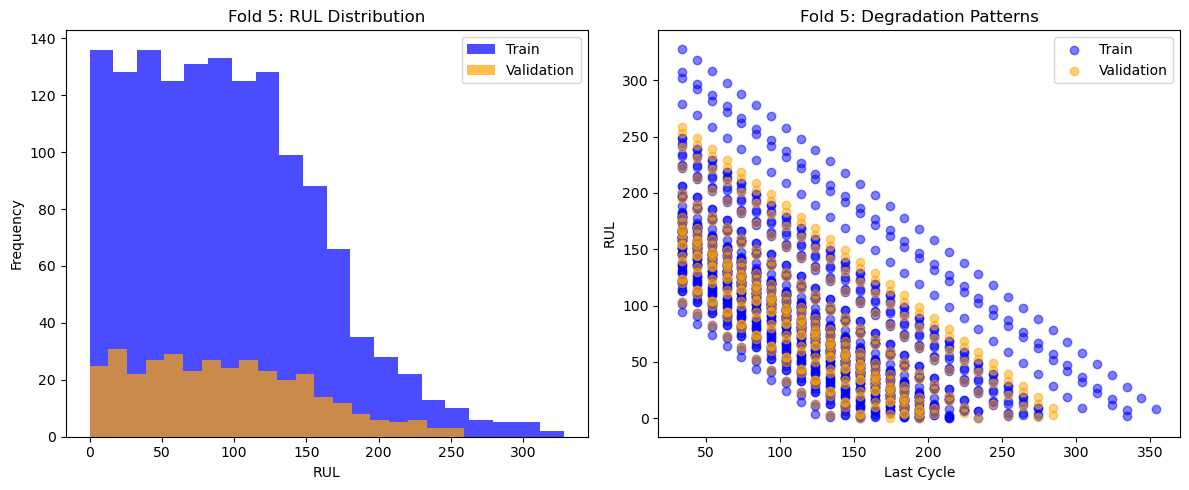

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def inspect_fold_characteristics(fold_loaders):
    """
    Inspects and visualizes RUL distribution and degradation patterns for each fold.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
    """
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Inspecting Fold {fold + 1}")
        
        # Initialize lists to collect RUL and Cycle data
        train_ruls, train_last_cycles = [], []
        val_ruls, val_last_cycles = [], []
        
        # Collect RUL and last cycles for training
        for _, targets, _, cycles in train_loader:
            train_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            train_last_cycles.extend(last_cycles.tolist())
        
        # Collect RUL and last cycles for validation
        for _, targets, _, cycles in val_loader:
            val_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            val_last_cycles.extend(last_cycles.tolist())
        
        # Convert to Pandas DataFrames for analysis
        train_df = pd.DataFrame({"RUL": train_ruls, "Last Cycle": train_last_cycles})
        val_df = pd.DataFrame({"RUL": val_ruls, "Last Cycle": val_last_cycles})
        
        # Print summary statistics
        print("  Training RUL Statistics:")
        print(train_df["RUL"].describe())
        print("  Validation RUL Statistics:")
        print(val_df["RUL"].describe())
        
        # Plot RUL distributions
        plt.figure(figsize=(12, 5))
        
        # RUL Distribution
        plt.subplot(1, 2, 1)
        plt.hist(train_df["RUL"], bins=20, alpha=0.7, label="Train", color="blue")
        plt.hist(val_df["RUL"], bins=20, alpha=0.7, label="Validation", color="orange")
        plt.xlabel("RUL")
        plt.ylabel("Frequency")
        plt.title(f"Fold {fold + 1}: RUL Distribution")
        plt.legend()

        # Degradation Patterns
        plt.subplot(1, 2, 2)
        plt.scatter(train_df["Last Cycle"], train_df["RUL"], alpha=0.5, label="Train", color="blue")
        plt.scatter(val_df["Last Cycle"], val_df["RUL"], alpha=0.5, label="Validation", color="orange")
        plt.xlabel("Last Cycle")
        plt.ylabel("RUL")
        plt.title(f"Fold {fold + 1}: Degradation Patterns")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function to inspect fold characteristics
inspect_fold_characteristics(fold_loaders)

# K-Fold evaluation and development of model as preparation for a final training

In [8]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from codebase.v4.models import FeatureProcessingGRU, GRUBasedModel, GRUWithAttention, MultiHeadGRU, CombinedNet
from tqdm.notebook import tqdm  # Use tqdm for Jupyter-friendly progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configuration
input_dim = len(dataset.feature_cols)  # Number of input features (contains engineered features)

def train_and_validate_kfold(fold_loaders, model_config, epochs=500, lr=0.001, weight_decay=1e-6, patience=10):
    """
    Train and validate the model using grouped k-fold cross-validation with early stopping.
    Summarizes metrics (e.g., RMSE, Avg MSE) across all folds.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
        model_config (dict): Configuration for the model (e.g., input_dim, hidden_dim, num_layers).
        epochs (int): Maximum number of epochs to train for each fold.
        lr (float): Learning rate for the optimizer.
        patience (int): Number of epochs with no improvement before stopping.

    Returns:
        dict: Summary of metrics across all folds.
    """
    # Track metrics for all folds
    fold_metrics = {
        "train_rmse": [],
        "val_rmse": [],
        "train_avg_mse": [],
        "val_avg_mse": [],
    }

    # Loop over each fold
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Validation Fold {fold + 1}")
        
        # Initialize model, loss function, and optimizer
        model = CombinedNet(**model_config)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Early stopping variables
        best_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False

        # Initialize progress bar for this fold
        total_batches = len(train_loader) * epochs
        with tqdm(total=total_batches, desc=f"Fold {fold + 1} Training", unit="batch") as pbar:
            for epoch in range(epochs):
                if early_stop:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
                
                model.train()
                train_loss = 0.0  # Track training loss
                num_train_sequences = len(train_loader.dataset)

                # Training loop
                for inputs, targets, _, _ in train_loader:
                    optimizer.zero_grad()
                    inputs, targets = inputs.to(device), targets.to(device)
                    
                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                    
                    # Accumulate loss
                    train_loss += loss.item() * inputs.size(0)
                    
                    # Update progress bar
                    pbar.update(1)
                
                # Compute training metrics
                avg_train_mse = train_loss / num_train_sequences
                train_rmse = avg_train_mse ** 0.5

                # Validation loop
                model.eval()
                val_loss = 0.0
                num_val_sequences = len(val_loader.dataset)
                with torch.no_grad():
                    for inputs, targets, _, _ in val_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        
                        # Forward pass
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        
                        # Accumulate validation loss
                        val_loss += loss.item() * inputs.size(0)
                
                # Compute validation metrics
                avg_val_mse = val_loss / num_val_sequences
                val_rmse = avg_val_mse ** 0.5

                # Check for early stopping
                if avg_val_mse < best_val_loss:
                    best_val_loss = avg_val_mse
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"No improvement for {epochs_no_improve} epoch(s).")

                if epochs_no_improve >= patience:
                    print("Early stopping triggered.")
                    early_stop = True

                # Print epoch metrics
                pbar.set_postfix({
                    "Epoch": f"{epoch + 1}/{epochs}",
                    "Train Loss": f"Avg MSE: {avg_train_mse:.4f}, RMSE: {train_rmse:.4f}",
                    "Val Loss:": f"Avg MSE: {avg_val_mse:.4f}, RMSE: {val_rmse:.4f}"
                })
                pbar.update(0)

        # Store fold metrics
        fold_metrics["train_rmse"].append(train_rmse)
        fold_metrics["val_rmse"].append(val_rmse)
        fold_metrics["train_avg_mse"].append(avg_train_mse)
        fold_metrics["val_avg_mse"].append(avg_val_mse)

    # Summarize metrics across all folds
    summary = {
        "mean_train_rmse": sum(fold_metrics["train_rmse"]) / len(fold_metrics["train_rmse"]),
        "mean_val_rmse": sum(fold_metrics["val_rmse"]) / len(fold_metrics["val_rmse"]),
        "mean_train_avg_mse": sum(fold_metrics["train_avg_mse"]) / len(fold_metrics["train_avg_mse"]),
        "mean_val_avg_mse": sum(fold_metrics["val_avg_mse"]) / len(fold_metrics["val_avg_mse"]),
    }

    print("\n--- k-Fold Cross-Validation Summary ---")
    for key, value in summary.items():
        print(f"{key}: {value:.4f}")

    return summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Define model configuration
model_config = {
    "input_dim": input_dim,
    "conv_configs": [(64, 3, 1), (128, 3, 1)],  # (out_channels, kernel_size, padding),
    "gru_hidden_dim": 512,
    "fc_hidden_dim": 256,
    "num_heads": 2,
    "num_layers": 4,
    "dropout": 0.3
}

learning_rate = 0.0026313112748361776

# Train using k-fold loaders
summary = train_and_validate_kfold(fold_loaders, model_config, epochs=500, lr=learning_rate, patience=10)

# K-Fold evaluation: Using Optuna for hyperparameter search
Let's use Optuna for an efficient hyperparameter search.

In [ ]:
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Calls the existing train_and_validate_kfold function.
    """
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 128, 512, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    #weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Create the model configuration for the trial
    # input_dim, hidden_dim=256, num_heads=3, num_layers=1, dropout=0.3
    model_config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "num_heads": num_heads,
        "num_layers": num_layers,
        "dropout": dropout
    }

    # Call your existing train_and_validate_kfold function
    summary = train_and_validate_kfold(
        fold_loaders=fold_loaders,
        model_config=model_config,
        epochs=100,  # Fewer epochs for faster tuning
        lr=lr,
        weight_decay=0.0,
        patience=10  # Early stopping patience
    )

    # Return the mean validation RMSE as the objective value
    return summary["mean_val_rmse"]

# Optuna study configuration
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=20)  # Number of trials for hyperparameter tuning

# Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# Training without K-Fold

In [5]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from codebase.v4.models import FeatureProcessingGRU, GRUBasedModel, GRUWithAttention, MultiHeadGRU, CombinedNet
from tqdm.notebook import tqdm  # Use tqdm for Jupyter-friendly progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configuration
input_dim = len(dataset.feature_cols)  # Number of input features (contains engineered features)

def train_and_validate_single_run(fold_loaders, model_config, epochs=500, lr=0.001, weight_decay=1e-6, patience=10):
    """
    Train and validate the model using a *single* train/validation set (no k-fold).
    Summarizes metrics (e.g., RMSE, Avg MSE) for this single train/val split.

    Args:
        fold_loaders (list): List containing a single (train_loader, val_loader) tuple.
        model_config (dict): Configuration for the model (e.g., input_dim, hidden_dim, num_layers).
        epochs (int): Maximum number of epochs to train.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay for regularization.
        patience (int): Number of epochs with no improvement before stopping.

    Returns:
        dict: Summary of metrics for the single train/val run.
    """
    # We'll use only the first tuple from fold_loaders
    train_loader, val_loader = fold_loaders[0]

    print("Using standard train/validation approach instead of k-fold.")

    # Track metrics for this single run
    fold_metrics = {
        "train_rmse": [],
        "val_rmse": [],
        "train_avg_mse": [],
        "val_avg_mse": [],
    }

    # Initialize model, loss function, and optimizer
    model = CombinedNet(**model_config)
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    # Initialize progress bar for this single run
    total_batches = len(train_loader) * epochs
    with tqdm(total=total_batches, desc="Training", unit="batch") as pbar:
        for epoch in range(epochs):
            if early_stop:
                print(f"Early stopping at epoch {epoch + 1}")
                break

            # ---------------------------
            # 1. Training
            # ---------------------------
            model.train()
            train_loss = 0.0
            num_train_sequences = len(train_loader.dataset)

            for inputs, targets, _, _ in train_loader:
                optimizer.zero_grad()
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                pbar.update(1)

            avg_train_mse = train_loss / num_train_sequences
            train_rmse = avg_train_mse ** 0.5

            # ---------------------------
            # 2. Validation
            # ---------------------------
            model.eval()
            val_loss = 0.0
            num_val_sequences = len(val_loader.dataset)

            with torch.no_grad():
                for inputs, targets, _, _ in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)

            avg_val_mse = val_loss / num_val_sequences
            val_rmse = avg_val_mse ** 0.5

            # ---------------------------
            # 3. Early Stopping Logic
            # ---------------------------
            if avg_val_mse < best_val_loss:
                best_val_loss = avg_val_mse
                epochs_no_improve = 0
                best_model_state = model.state_dict()  # Save the best model's state
            else:
                epochs_no_improve += 1
                print(f"No improvement for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                early_stop = True

            # ---------------------------
            # 4. TQDM Logging
            # ---------------------------
            pbar.set_postfix({
                "Epoch": f"{epoch + 1}/{epochs}",
                "Train Loss": f"Avg MSE: {avg_train_mse:.4f}, RMSE: {train_rmse:.4f}",
                "Val Loss": f"Avg MSE: {avg_val_mse:.4f}, RMSE: {val_rmse:.4f}"
            })
            pbar.update(0)

    # Store final metrics
    fold_metrics["train_rmse"].append(train_rmse)
    fold_metrics["val_rmse"].append(val_rmse)
    fold_metrics["train_avg_mse"].append(avg_train_mse)
    fold_metrics["val_avg_mse"].append(avg_val_mse)

    # Summarize metrics for this single run
    summary = {
        "mean_train_rmse": sum(fold_metrics["train_rmse"]) / len(fold_metrics["train_rmse"]),
        "mean_val_rmse": sum(fold_metrics["val_rmse"]) / len(fold_metrics["val_rmse"]),
        "mean_train_avg_mse": sum(fold_metrics["train_avg_mse"]) / len(fold_metrics["train_avg_mse"]),
        "mean_val_avg_mse": sum(fold_metrics["val_avg_mse"]) / len(fold_metrics["val_avg_mse"]),
    }

    print("\n--- Train/Validation Summary ---")
    for key, value in summary.items():
        print(f"{key}: {value:.4f}")

    return best_model_state, summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Define model configuration
# Trial 5 finished with value: 44.50249345630113 and parameters: 
# {'fc_hidden_dim': 192, 'gru_hidden_dim': 512, 'num_layers': 4, 'num_heads': 3, 
# 'dropout': 0.10750046093315908, 'lr': 0.002824913366245818, 
# 'weight_decay': 2.7005914935249046e-06, 'conv_0_out_channels': 256, 
# 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}
model_config = {
    "input_dim": input_dim,
    "conv_configs": [(256, 3, 1), (128, 1, 0)],  # (out_channels, kernel_size, padding),
    "gru_hidden_dim": 512,
    "fc_hidden_dim": 192,
    "num_heads": 3,
    "num_layers": 4,
    "dropout": 0.10750046093315908,
    "attention_heads": 4
}

learning_rate = 0.002824913366245818

# Train using k-fold loaders
model_weights, summary = train_and_validate_single_run(
        fold_loaders=fold_loaders,
        model_config=model_config,
        epochs=100,  # Fewer epochs for faster tuning
        lr=learning_rate,
        weight_decay=0.0,
        patience=10  # Early stopping patience
    )

Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 512
FC Hidden Dim: 192
Number of Heads (GRU): 3
Number of Layers (GRU): 4
Dropout Rate: 0.10750046093315908
Attention Heads (MHA): 4


Training:   0%|          | 0/200 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 27

--- Train/Validation Summary ---
mean_train_rmse: 41.1537
mean_val_rmse: 53.7615
mean_train_avg_mse: 1693.6276
mean_val_avg_mse: 2890.2983


# Training without K-Fold: Optuna

In [7]:
import optuna

def suggest_conv_configs(trial, num_layers=2):
    """
    Suggests convolutional layer configurations for a model.

    Args:
        trial (optuna.Trial): Optuna trial object.
        num_layers (int): Number of convolutional layers to suggest.

    Returns:
        list: List of tuples representing conv layer configurations.
    """
    conv_configs = []
    for i in range(num_layers):
        out_channels = trial.suggest_categorical(f"conv_{i}_out_channels", [32, 64, 128, 256])
        kernel_size = trial.suggest_int(f"conv_{i}_kernel_size", 1, 5, step=2)  # Odd kernel sizes (1, 3, 5)
        padding = trial.suggest_int(f"conv_{i}_padding", 0, kernel_size // 2)  # Ensure valid padding
        conv_configs.append((out_channels, kernel_size, padding))
    
    return conv_configs

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Calls the existing train_and_validate_kfold function.
    """
    # Suggest hyperparameters
    fc_hidden_dim = trial.suggest_int("fc_hidden_dim", 128, 512, step=64)
    gru_hidden_dim = trial.suggest_int("gru_hidden_dim", 128, 512, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    conv_configs = suggest_conv_configs(trial)

    # Create the model configuration for the trial
    # input_dim, hidden_dim=256, num_heads=3, num_layers=1, dropout=0.3
    model_config = {
        "input_dim": input_dim,
        "conv_configs": conv_configs,  # (out_channels, kernel_size, padding),
        "gru_hidden_dim": gru_hidden_dim,
        "fc_hidden_dim": fc_hidden_dim,
        "num_heads": num_heads,
        "num_layers": num_layers,
        "dropout": dropout
    }

    # Call your existing train_and_validate_kfold function
    weights, summary = train_and_validate_single_run(
        fold_loaders=fold_loaders,
        model_config=model_config,
        epochs=50,  # Fewer epochs for faster tuning
        lr=lr,
        weight_decay=weight_decay,
        patience=10  # Early stopping patience
    )

    # Return the mean validation RMSE as the objective value
    return summary["mean_val_rmse"]

# Optuna study configuration
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Number of trials for hyperparameter tuning

# Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

[I 2025-01-12 15:29:07,620] A new study created in memory with name: no-name-f096bdd2-48e1-456f-b0bb-4bf978a844ae


Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 1, 0), (256, 5, 1)]
GRU Hidden Dim: 128
FC Hidden Dim: 192
Number of Heads: 4
Number of Layers: 4
Dropout Rate: 0.4123158815782697


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:30:17,646] Trial 0 finished with value: 48.47808027942242 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 128, 'num_layers': 4, 'num_heads': 4, 'dropout': 0.4123158815782697, 'lr': 0.0006829343739513299, 'weight_decay': 1.5553032882107056e-05, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 1, 'conv_0_padding': 0, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 5, 'conv_1_padding': 1}. Best is trial 0 with value: 48.47808027942242.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 38

--- Train/Validation Summary ---
mean_train_rmse: 42.3959
mean_val_rmse: 48.4781
mean_train_avg_mse: 1797.4119
mean_val_avg_mse: 2350.1243
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 5, 2), (256, 5, 0)]
GRU Hidden Dim: 192
FC Hidden Dim: 128
Number of Heads: 2
Number of Layers: 1
Dropout Rate: 0.32047662234105534


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

[I 2025-01-12 15:31:50,470] Trial 1 finished with value: 69.14263591708448 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 192, 'num_layers': 1, 'num_heads': 2, 'dropout': 0.32047662234105534, 'lr': 0.0002777751885217859, 'weight_decay': 1.8796209375904636e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 5, 'conv_0_padding': 2, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 5, 'conv_1_padding': 0}. Best is trial 0 with value: 48.47808027942242.



--- Train/Validation Summary ---
mean_train_rmse: 66.6637
mean_val_rmse: 69.1426
mean_train_avg_mse: 4444.0498
mean_val_avg_mse: 4780.7041
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(128, 1, 0), (32, 3, 0)]
GRU Hidden Dim: 320
FC Hidden Dim: 512
Number of Heads: 1
Number of Layers: 3
Dropout Rate: 0.4431444384536867


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:33:00,696] Trial 2 finished with value: 47.38952768264709 and parameters: {'fc_hidden_dim': 512, 'gru_hidden_dim': 320, 'num_layers': 3, 'num_heads': 1, 'dropout': 0.4431444384536867, 'lr': 0.0059734907989130274, 'weight_decay': 8.995984870665695e-06, 'conv_0_out_channels': 128, 'conv_0_kernel_size': 1, 'conv_0_padding': 0, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 3, 'conv_1_padding': 0}. Best is trial 2 with value: 47.38952768264709.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 38

--- Train/Validation Summary ---
mean_train_rmse: 40.6959
mean_val_rmse: 47.3895
mean_train_avg_mse: 1656.1597
mean_val_avg_mse: 2245.7673
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(128, 5, 2), (64, 3, 1)]
GRU Hidden Dim: 128
FC Hidden Dim: 192
Number of Heads: 4
Number of Layers: 4
Dropout Rate: 0.278149229303181


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:34:29,562] Trial 3 finished with value: 48.74975460675417 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 128, 'num_layers': 4, 'num_heads': 4, 'dropout': 0.278149229303181, 'lr': 0.0017050462242745943, 'weight_decay': 7.391312075332587e-05, 'conv_0_out_channels': 128, 'conv_0_kernel_size': 5, 'conv_0_padding': 2, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 2 with value: 47.38952768264709.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 49

--- Train/Validation Summary ---
mean_train_rmse: 40.7611
mean_val_rmse: 48.7498
mean_train_avg_mse: 1661.4698
mean_val_avg_mse: 2376.5386
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 1, 0), (32, 5, 0)]
GRU Hidden Dim: 512
FC Hidden Dim: 384
Number of Heads: 2
Number of Layers: 1
Dropout Rate: 0.3872620875480053


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:35:34,731] Trial 4 finished with value: 56.9097228312911 and parameters: {'fc_hidden_dim': 384, 'gru_hidden_dim': 512, 'num_layers': 1, 'num_heads': 2, 'dropout': 0.3872620875480053, 'lr': 0.0015917821017373821, 'weight_decay': 3.221177200519295e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 1, 'conv_0_padding': 0, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 5, 'conv_1_padding': 0}. Best is trial 2 with value: 47.38952768264709.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 35

--- Train/Validation Summary ---
mean_train_rmse: 35.4497
mean_val_rmse: 56.9097
mean_train_avg_mse: 1256.6822
mean_val_avg_mse: 3238.7166
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 512
FC Hidden Dim: 192
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.10750046093315908


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-12 15:37:15,818] Trial 5 finished with value: 44.50249345630113 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 512, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.10750046093315908, 'lr': 0.002824913366245818, 'weight_decay': 2.7005914935249046e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 2 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 33.7055
mean_val_rmse: 44.5025
mean_train_avg_mse: 1136.0639
mean_val_avg_mse: 1980.4719
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 3, 0), (64, 5, 1)]
GRU Hidden Dim: 448
FC Hidden Dim: 384
Number of Heads: 3
Number of Layers: 2
Dropout Rate: 0.33625148873086375


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:38:12,370] Trial 6 finished with value: 49.00920174282326 and parameters: {'fc_hidden_dim': 384, 'gru_hidden_dim': 448, 'num_layers': 2, 'num_heads': 3, 'dropout': 0.33625148873086375, 'lr': 0.0017306748497804753, 'weight_decay': 6.182638302380239e-05, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 3, 'conv_0_padding': 0, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 5, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 31

--- Train/Validation Summary ---
mean_train_rmse: 38.6181
mean_val_rmse: 49.0092
mean_train_avg_mse: 1491.3567
mean_val_avg_mse: 2401.9019
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 1, 0), (32, 5, 0)]
GRU Hidden Dim: 448
FC Hidden Dim: 384
Number of Heads: 2
Number of Layers: 3
Dropout Rate: 0.19153752537701424


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

[I 2025-01-12 15:39:45,829] Trial 7 finished with value: 48.984536981390875 and parameters: {'fc_hidden_dim': 384, 'gru_hidden_dim': 448, 'num_layers': 3, 'num_heads': 2, 'dropout': 0.19153752537701424, 'lr': 0.00018713099906986376, 'weight_decay': 2.5475899827976245e-06, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 1, 'conv_0_padding': 0, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 5, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 43.3689
mean_val_rmse: 48.9845
mean_train_avg_mse: 1880.8645
mean_val_avg_mse: 2399.4849
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(128, 5, 2), (128, 1, 0)]
GRU Hidden Dim: 320
FC Hidden Dim: 320
Number of Heads: 4
Number of Layers: 1
Dropout Rate: 0.20743282395020973


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:40:40,292] Trial 8 finished with value: 50.17473860949601 and parameters: {'fc_hidden_dim': 320, 'gru_hidden_dim': 320, 'num_layers': 1, 'num_heads': 4, 'dropout': 0.20743282395020973, 'lr': 0.0010750238978324241, 'weight_decay': 1.1365773293364215e-05, 'conv_0_out_channels': 128, 'conv_0_kernel_size': 5, 'conv_0_padding': 2, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 30

--- Train/Validation Summary ---
mean_train_rmse: 35.5824
mean_val_rmse: 50.1747
mean_train_avg_mse: 1266.1089
mean_val_avg_mse: 2517.5044
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 5, 0), (32, 3, 0)]
GRU Hidden Dim: 256
FC Hidden Dim: 384
Number of Heads: 3
Number of Layers: 3
Dropout Rate: 0.2300642996011126


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:41:44,646] Trial 9 finished with value: 48.69872604051106 and parameters: {'fc_hidden_dim': 384, 'gru_hidden_dim': 256, 'num_layers': 3, 'num_heads': 3, 'dropout': 0.2300642996011126, 'lr': 0.004761410210606224, 'weight_decay': 1.4583763496454938e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 5, 'conv_0_padding': 0, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 3, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 34

--- Train/Validation Summary ---
mean_train_rmse: 41.2842
mean_val_rmse: 48.6987
mean_train_avg_mse: 1704.3872
mean_val_avg_mse: 2371.5659
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 512
FC Hidden Dim: 256
Number of Heads: 1
Number of Layers: 4
Dropout Rate: 0.1222370529972636


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:42:51,652] Trial 10 finished with value: 48.527137321715415 and parameters: {'fc_hidden_dim': 256, 'gru_hidden_dim': 512, 'num_layers': 4, 'num_heads': 1, 'dropout': 0.1222370529972636, 'lr': 0.008945516023741523, 'weight_decay': 1.8067201332594753e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 36

--- Train/Validation Summary ---
mean_train_rmse: 40.1301
mean_val_rmse: 48.5271
mean_train_avg_mse: 1610.4268
mean_val_avg_mse: 2354.8831
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 384
FC Hidden Dim: 512
Number of Heads: 1
Number of Layers: 3
Dropout Rate: 0.448294750592181


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:43:50,154] Trial 11 finished with value: 47.12233704346061 and parameters: {'fc_hidden_dim': 512, 'gru_hidden_dim': 384, 'num_layers': 3, 'num_heads': 1, 'dropout': 0.448294750592181, 'lr': 0.004369441926725201, 'weight_decay': 3.725802649915875e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 32

--- Train/Validation Summary ---
mean_train_rmse: 40.4478
mean_val_rmse: 47.1223
mean_train_avg_mse: 1636.0247
mean_val_avg_mse: 2220.5146
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 384
FC Hidden Dim: 512
Number of Heads: 3
Number of Layers: 2
Dropout Rate: 0.48871755355620344


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:44:29,200] Trial 12 finished with value: 47.746354368357274 and parameters: {'fc_hidden_dim': 512, 'gru_hidden_dim': 384, 'num_layers': 2, 'num_heads': 3, 'dropout': 0.48871755355620344, 'lr': 0.00352801526973864, 'weight_decay': 3.957477324482329e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 22

--- Train/Validation Summary ---
mean_train_rmse: 37.9700
mean_val_rmse: 47.7464
mean_train_avg_mse: 1441.7213
mean_val_avg_mse: 2279.7144
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 384
FC Hidden Dim: 256
Number of Heads: 1
Number of Layers: 4
Dropout Rate: 0.123648300867001


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:45:01,338] Trial 13 finished with value: 59.22049387274012 and parameters: {'fc_hidden_dim': 256, 'gru_hidden_dim': 384, 'num_layers': 4, 'num_heads': 1, 'dropout': 0.123648300867001, 'lr': 0.003476036410323297, 'weight_decay': 1.145365809034864e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 18

--- Train/Validation Summary ---
mean_train_rmse: 54.1530
mean_val_rmse: 59.2205
mean_train_avg_mse: 2932.5444
mean_val_avg_mse: 3507.0669
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 448
FC Hidden Dim: 128
Number of Heads: 2
Number of Layers: 3
Dropout Rate: 0.4889543025788781


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).


[I 2025-01-12 15:46:36,152] Trial 14 finished with value: 45.08606678308444 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 448, 'num_layers': 3, 'num_heads': 2, 'dropout': 0.4889543025788781, 'lr': 0.0004170398518315945, 'weight_decay': 5.187778309581285e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 40.2973
mean_val_rmse: 45.0861
mean_train_avg_mse: 1623.8748
mean_val_avg_mse: 2032.7534
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 512
FC Hidden Dim: 128
Number of Heads: 3
Number of Layers: 2
Dropout Rate: 0.2650520782299964


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).


[I 2025-01-12 15:48:29,148] Trial 15 finished with value: 46.769490631246455 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 512, 'num_layers': 2, 'num_heads': 3, 'dropout': 0.2650520782299964, 'lr': 0.0004019742421679159, 'weight_decay': 6.096610415148787e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 9 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 34.0606
mean_val_rmse: 46.7695
mean_train_avg_mse: 1160.1272
mean_val_avg_mse: 2187.3853
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 3, 1)]
GRU Hidden Dim: 448
FC Hidden Dim: 192
Number of Heads: 2
Number of Layers: 4
Dropout Rate: 0.16177111898263913


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-12 15:50:07,278] Trial 16 finished with value: 45.8245422440312 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 448, 'num_layers': 4, 'num_heads': 2, 'dropout': 0.16177111898263913, 'lr': 0.00047314184749468104, 'weight_decay': 6.215414055704959e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.


No improvement for 1 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 38.9554
mean_val_rmse: 45.8245
mean_train_avg_mse: 1517.5262
mean_val_avg_mse: 2099.8887
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 5, 2), (128, 1, 0)]
GRU Hidden Dim: 448
FC Hidden Dim: 128
Number of Heads: 3
Number of Layers: 3
Dropout Rate: 0.37953224042502137


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

[I 2025-01-12 15:51:44,770] Trial 17 finished with value: 73.15331649927944 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 448, 'num_layers': 3, 'num_heads': 3, 'dropout': 0.37953224042502137, 'lr': 0.00011968620526055997, 'weight_decay': 1.0815110817847457e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 5, 'conv_0_padding': 2, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 71.0854
mean_val_rmse: 73.1533
mean_train_avg_mse: 5053.1364
mean_val_avg_mse: 5351.4077
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (64, 3, 1)]
GRU Hidden Dim: 512
FC Hidden Dim: 256
Number of Heads: 2
Number of Layers: 4
Dropout Rate: 0.4971787332372757


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:52:36,687] Trial 18 finished with value: 52.68989791029088 and parameters: {'fc_hidden_dim': 256, 'gru_hidden_dim': 512, 'num_layers': 4, 'num_heads': 2, 'dropout': 0.4971787332372757, 'lr': 0.0006785842831443385, 'weight_decay': 2.2214836008077734e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 28

--- Train/Validation Summary ---
mean_train_rmse: 45.5869
mean_val_rmse: 52.6899
mean_train_avg_mse: 2078.1641
mean_val_avg_mse: 2776.2253
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 1, 0), (256, 1, 0)]
GRU Hidden Dim: 384
FC Hidden Dim: 192
Number of Heads: 3
Number of Layers: 3
Dropout Rate: 0.349207330929876


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:53:21,772] Trial 19 finished with value: 51.968620809370385 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 384, 'num_layers': 3, 'num_heads': 3, 'dropout': 0.349207330929876, 'lr': 0.0024776291084697916, 'weight_decay': 4.542772456408118e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 1, 'conv_0_padding': 0, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 24

--- Train/Validation Summary ---
mean_train_rmse: 34.3067
mean_val_rmse: 51.9686
mean_train_avg_mse: 1176.9479
mean_val_avg_mse: 2700.7375
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 3, 1)]
GRU Hidden Dim: 320
FC Hidden Dim: 128
Number of Heads: 2
Number of Layers: 2
Dropout Rate: 0.2539070007933281


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:54:41,866] Trial 20 finished with value: 49.734001922885966 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 320, 'num_layers': 2, 'num_heads': 2, 'dropout': 0.2539070007933281, 'lr': 0.0010056906901526113, 'weight_decay': 2.543902006970262e-05, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 42

--- Train/Validation Summary ---
mean_train_rmse: 29.0811
mean_val_rmse: 49.7340
mean_train_avg_mse: 845.7098
mean_val_avg_mse: 2473.4709
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 3, 1)]
GRU Hidden Dim: 448
FC Hidden Dim: 192
Number of Heads: 2
Number of Layers: 4
Dropout Rate: 0.16321401137855132


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:56:14,988] Trial 21 finished with value: 46.82184486166687 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 448, 'num_layers': 4, 'num_heads': 2, 'dropout': 0.16321401137855132, 'lr': 0.000409554301670994, 'weight_decay': 6.724396774746717e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 48

--- Train/Validation Summary ---
mean_train_rmse: 41.2644
mean_val_rmse: 46.8218
mean_train_avg_mse: 1702.7529
mean_val_avg_mse: 2192.2852
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 3, 1)]
GRU Hidden Dim: 448
FC Hidden Dim: 192
Number of Heads: 2
Number of Layers: 4
Dropout Rate: 0.15481907802699485


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 15:57:49,509] Trial 22 finished with value: 48.57036465032587 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 448, 'num_layers': 4, 'num_heads': 2, 'dropout': 0.15481907802699485, 'lr': 0.0005675532389125537, 'weight_decay': 2.9122083244373163e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 50

--- Train/Validation Summary ---
mean_train_rmse: 33.7578
mean_val_rmse: 48.5704
mean_train_avg_mse: 1139.5864
mean_val_avg_mse: 2359.0803
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 512
FC Hidden Dim: 256
Number of Heads: 2
Number of Layers: 4
Dropout Rate: 0.15985126549566595


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-12 15:59:25,888] Trial 23 finished with value: 46.44406603142376 and parameters: {'fc_hidden_dim': 256, 'gru_hidden_dim': 512, 'num_layers': 4, 'num_heads': 2, 'dropout': 0.15985126549566595, 'lr': 0.0002236960840583403, 'weight_decay': 6.293516122496318e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 2 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 40.7783
mean_val_rmse: 46.4441
mean_train_avg_mse: 1662.8691
mean_val_avg_mse: 2157.0513
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 1, 0)]
GRU Hidden Dim: 448
FC Hidden Dim: 320
Number of Heads: 3
Number of Layers: 3
Dropout Rate: 0.11216341207534461


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:00:39,262] Trial 24 finished with value: 46.58604165781581 and parameters: {'fc_hidden_dim': 320, 'gru_hidden_dim': 448, 'num_layers': 3, 'num_heads': 3, 'dropout': 0.11216341207534461, 'lr': 0.00038295958124260054, 'weight_decay': 8.285581031546726e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 39

--- Train/Validation Summary ---
mean_train_rmse: 34.1510
mean_val_rmse: 46.5860
mean_train_avg_mse: 1166.2922
mean_val_avg_mse: 2170.2593
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 5, 2), (128, 3, 1)]
GRU Hidden Dim: 512
FC Hidden Dim: 128
Number of Heads: 2
Number of Layers: 4
Dropout Rate: 0.10366117298678484


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:02:15,759] Trial 25 finished with value: 50.39605348666947 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 512, 'num_layers': 4, 'num_heads': 2, 'dropout': 0.10366117298678484, 'lr': 0.0011448434711528763, 'weight_decay': 1.8337813531354426e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 5, 'conv_0_padding': 2, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 50

--- Train/Validation Summary ---
mean_train_rmse: 40.2362
mean_val_rmse: 50.3961
mean_train_avg_mse: 1618.9528
mean_val_avg_mse: 2539.7622
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 1, 0), (128, 1, 0)]
GRU Hidden Dim: 384
FC Hidden Dim: 320
Number of Heads: 1
Number of Layers: 3
Dropout Rate: 0.19520746894980376


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

[I 2025-01-12 16:03:51,393] Trial 26 finished with value: 88.13991451805475 and parameters: {'fc_hidden_dim': 320, 'gru_hidden_dim': 384, 'num_layers': 3, 'num_heads': 1, 'dropout': 0.19520746894980376, 'lr': 0.00013466365721013005, 'weight_decay': 4.321552723467881e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 1, 'conv_0_padding': 0, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 85.7478
mean_val_rmse: 88.1399
mean_train_avg_mse: 7352.6864
mean_val_avg_mse: 7768.6445
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 3, 1), (256, 3, 1)]
GRU Hidden Dim: 256
FC Hidden Dim: 192
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.14228781651260933


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).


[I 2025-01-12 16:05:28,274] Trial 27 finished with value: 45.863918535571074 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 256, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.14228781651260933, 'lr': 0.00029188684622527235, 'weight_decay': 1.5178317118519907e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 39.7415
mean_val_rmse: 45.8639
mean_train_avg_mse: 1579.3856
mean_val_avg_mse: 2103.4990
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(128, 3, 1), (64, 1, 0)]
GRU Hidden Dim: 448
FC Hidden Dim: 128
Number of Heads: 4
Number of Layers: 4
Dropout Rate: 0.30455394668263813


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:06:34,032] Trial 28 finished with value: 47.3024598205857 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 448, 'num_layers': 4, 'num_heads': 4, 'dropout': 0.30455394668263813, 'lr': 0.0005466755170754802, 'weight_decay': 2.7424640392446507e-06, 'conv_0_out_channels': 128, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 32

--- Train/Validation Summary ---
mean_train_rmse: 42.9440
mean_val_rmse: 47.3025
mean_train_avg_mse: 1844.1899
mean_val_avg_mse: 2237.5227
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 1, 0), (256, 3, 1)]
GRU Hidden Dim: 512
FC Hidden Dim: 192
Number of Heads: 4
Number of Layers: 4
Dropout Rate: 0.23351527631880714


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:07:58,481] Trial 29 finished with value: 47.17786791179869 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 512, 'num_layers': 4, 'num_heads': 4, 'dropout': 0.23351527631880714, 'lr': 0.000751326160221012, 'weight_decay': 5.089108137387304e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 1, 'conv_0_padding': 0, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 41

--- Train/Validation Summary ---
mean_train_rmse: 35.8354
mean_val_rmse: 47.1779
mean_train_avg_mse: 1284.1749
mean_val_avg_mse: 2225.7512
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(256, 3, 1), (128, 5, 2)]
GRU Hidden Dim: 384
FC Hidden Dim: 256
Number of Heads: 2
Number of Layers: 3
Dropout Rate: 0.18019750631349468


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

[I 2025-01-12 16:09:33,383] Trial 30 finished with value: 57.33580283827353 and parameters: {'fc_hidden_dim': 256, 'gru_hidden_dim': 384, 'num_layers': 3, 'num_heads': 2, 'dropout': 0.18019750631349468, 'lr': 0.00018331933898279906, 'weight_decay': 1.3034029630639428e-05, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 5, 'conv_1_padding': 2}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 54.7496
mean_val_rmse: 57.3358
mean_train_avg_mse: 2997.5197
mean_val_avg_mse: 3287.3943
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 3, 1), (256, 3, 1)]
GRU Hidden Dim: 256
FC Hidden Dim: 192
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.14210294616821215


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).


[I 2025-01-12 16:11:12,609] Trial 31 finished with value: 47.08335724326458 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 256, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.14210294616821215, 'lr': 0.00031315214629366194, 'weight_decay': 1.3269853633993704e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 39.7116
mean_val_rmse: 47.0834
mean_train_avg_mse: 1577.0137
mean_val_avg_mse: 2216.8425
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 3, 1), (256, 3, 1)]
GRU Hidden Dim: 256
FC Hidden Dim: 192
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.1373961242889346


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

[I 2025-01-12 16:12:52,019] Trial 32 finished with value: 47.01840823433547 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 256, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.1373961242889346, 'lr': 0.00027302444005249923, 'weight_decay': 1.765187026571807e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 42.8372
mean_val_rmse: 47.0184
mean_train_avg_mse: 1835.0232
mean_val_avg_mse: 2210.7307
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 3, 1), (256, 3, 1)]
GRU Hidden Dim: 192
FC Hidden Dim: 128
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.2166346027349439


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:14:32,722] Trial 33 finished with value: 45.778047562908085 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 192, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.2166346027349439, 'lr': 0.0007343373829227916, 'weight_decay': 3.113841654396208e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 35.8653
mean_val_rmse: 45.7780
mean_train_avg_mse: 1286.3222
mean_val_avg_mse: 2095.6296
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 5, 2), (256, 3, 1)]
GRU Hidden Dim: 128
FC Hidden Dim: 128
Number of Heads: 2
Number of Layers: 4
Dropout Rate: 0.22704367092929412


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

[I 2025-01-12 16:16:08,145] Trial 34 finished with value: 48.19062591190583 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 128, 'num_layers': 4, 'num_heads': 2, 'dropout': 0.22704367092929412, 'lr': 0.0006718588249410632, 'weight_decay': 3.433251598383038e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 5, 'conv_0_padding': 2, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.



--- Train/Validation Summary ---
mean_train_rmse: 43.1891
mean_val_rmse: 48.1906
mean_train_avg_mse: 1865.2987
mean_val_avg_mse: 2322.3364
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (256, 5, 2)]
GRU Hidden Dim: 128
FC Hidden Dim: 128
Number of Heads: 4
Number of Layers: 3
Dropout Rate: 0.28941351218512473


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:17:34,476] Trial 35 finished with value: 46.121752616884855 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 128, 'num_layers': 3, 'num_heads': 4, 'dropout': 0.28941351218512473, 'lr': 0.00138086189133068, 'weight_decay': 8.380643039078268e-06, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 256, 'conv_1_kernel_size': 5, 'conv_1_padding': 2}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 46

--- Train/Validation Summary ---
mean_train_rmse: 34.4343
mean_val_rmse: 46.1218
mean_train_avg_mse: 1185.7177
mean_val_avg_mse: 2127.2161
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(128, 1, 0), (32, 3, 1)]
GRU Hidden Dim: 192
FC Hidden Dim: 128
Number of Heads: 2
Number of Layers: 4
Dropout Rate: 0.4489752678400666


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:19:06,710] Trial 36 finished with value: 48.876783255511505 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 192, 'num_layers': 4, 'num_heads': 2, 'dropout': 0.4489752678400666, 'lr': 0.002420235622615934, 'weight_decay': 2.0716553587524318e-05, 'conv_0_out_channels': 128, 'conv_0_kernel_size': 1, 'conv_0_padding': 0, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 3, 'conv_1_padding': 1}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 47

--- Train/Validation Summary ---
mean_train_rmse: 39.2358
mean_val_rmse: 48.8768
mean_train_avg_mse: 1539.4462
mean_val_avg_mse: 2388.9399
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 3, 1), (64, 5, 2)]
GRU Hidden Dim: 192
FC Hidden Dim: 128
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.1830145560696289


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).


[I 2025-01-12 16:20:49,511] Trial 37 finished with value: 45.248378661388244 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 192, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.1830145560696289, 'lr': 0.0004844095243678917, 'weight_decay': 5.427994491397905e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 5, 'conv_1_padding': 2}. Best is trial 5 with value: 44.50249345630113.


No improvement for 2 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 39.7465
mean_val_rmse: 45.2484
mean_train_avg_mse: 1579.7857
mean_val_avg_mse: 2047.4158
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 3, 1), (64, 5, 2)]
GRU Hidden Dim: 192
FC Hidden Dim: 128
Number of Heads: 3
Number of Layers: 3
Dropout Rate: 0.41602959456584415


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).


[I 2025-01-12 16:22:26,775] Trial 38 finished with value: 47.150298352880284 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 192, 'num_layers': 3, 'num_heads': 3, 'dropout': 0.41602959456584415, 'lr': 0.0008133170257775115, 'weight_decay': 3.178102184815242e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 5, 'conv_1_padding': 2}. Best is trial 5 with value: 44.50249345630113.


No improvement for 7 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 35.9384
mean_val_rmse: 47.1503
mean_train_avg_mse: 1291.5715
mean_val_avg_mse: 2223.1506
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 5, 2), (64, 5, 2)]
GRU Hidden Dim: 192
FC Hidden Dim: 128
Number of Heads: 4
Number of Layers: 2
Dropout Rate: 0.2100588338365848


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:23:28,239] Trial 39 finished with value: 48.76657620828148 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 192, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.2100588338365848, 'lr': 0.0021587202067536934, 'weight_decay': 5.1563778764025584e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 5, 'conv_0_padding': 2, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 5, 'conv_1_padding': 2}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 32

--- Train/Validation Summary ---
mean_train_rmse: 30.9565
mean_val_rmse: 48.7666
mean_train_avg_mse: 958.3033
mean_val_avg_mse: 2378.1790
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(64, 1, 0), (64, 5, 2)]
GRU Hidden Dim: 320
FC Hidden Dim: 448
Number of Heads: 3
Number of Layers: 1
Dropout Rate: 0.31401952105490194


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:24:51,523] Trial 40 finished with value: 48.481650745249745 and parameters: {'fc_hidden_dim': 448, 'gru_hidden_dim': 320, 'num_layers': 1, 'num_heads': 3, 'dropout': 0.31401952105490194, 'lr': 0.0012633009460388468, 'weight_decay': 2.1967082122596467e-06, 'conv_0_out_channels': 64, 'conv_0_kernel_size': 1, 'conv_0_padding': 0, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 5, 'conv_1_padding': 2}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 44

--- Train/Validation Summary ---
mean_train_rmse: 33.6189
mean_val_rmse: 48.4817
mean_train_avg_mse: 1130.2286
mean_val_avg_mse: 2350.4705
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (64, 3, 0)]
GRU Hidden Dim: 128
FC Hidden Dim: 192
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.17150745058512445


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).


[I 2025-01-12 16:26:29,493] Trial 41 finished with value: 45.66018281743816 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 128, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.17150745058512445, 'lr': 0.0008907519107143124, 'weight_decay': 1.0523130593906412e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 3, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 5 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 36.5274
mean_val_rmse: 45.6602
mean_train_avg_mse: 1334.2484
mean_val_avg_mse: 2084.8523
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (64, 5, 2)]
GRU Hidden Dim: 128
FC Hidden Dim: 192
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.18303958440692839


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).


[I 2025-01-12 16:28:06,215] Trial 42 finished with value: 47.610997982674654 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 128, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.18303958440692839, 'lr': 0.0008733361973273555, 'weight_decay': 1.0737002367338316e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 5, 'conv_1_padding': 2}. Best is trial 5 with value: 44.50249345630113.


No improvement for 8 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 35.4426
mean_val_rmse: 47.6110
mean_train_avg_mse: 1256.1752
mean_val_avg_mse: 2266.8071
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (64, 1, 0)]
GRU Hidden Dim: 128
FC Hidden Dim: 128
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.21017201758926998


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:29:11,775] Trial 43 finished with value: 49.69102287039632 and parameters: {'fc_hidden_dim': 128, 'gru_hidden_dim': 128, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.21017201758926998, 'lr': 0.00864559972980112, 'weight_decay': 8.324709533400762e-06, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 34

--- Train/Validation Summary ---
mean_train_rmse: 36.8002
mean_val_rmse: 49.6910
mean_train_avg_mse: 1354.2520
mean_val_avg_mse: 2469.1978
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (64, 3, 0)]
GRU Hidden Dim: 192
FC Hidden Dim: 192
Number of Heads: 3
Number of Layers: 4
Dropout Rate: 0.10097362422455748


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).


[I 2025-01-12 16:30:51,306] Trial 44 finished with value: 46.68814580794974 and parameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 192, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.10097362422455748, 'lr': 0.000553568213730225, 'weight_decay': 1.7317490464114303e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 64, 'conv_1_kernel_size': 3, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 4 epoch(s).

--- Train/Validation Summary ---
mean_train_rmse: 36.1403
mean_val_rmse: 46.6881
mean_train_avg_mse: 1306.1211
mean_val_avg_mse: 2179.7830
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (32, 1, 0)]
GRU Hidden Dim: 128
FC Hidden Dim: 256
Number of Heads: 3
Number of Layers: 3
Dropout Rate: 0.2583216792839647


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:32:18,187] Trial 45 finished with value: 45.52044151480876 and parameters: {'fc_hidden_dim': 256, 'gru_hidden_dim': 128, 'num_layers': 3, 'num_heads': 3, 'dropout': 0.2583216792839647, 'lr': 0.0017118299038858754, 'weight_decay': 5.620712055615496e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 46

--- Train/Validation Summary ---
mean_train_rmse: 35.0480
mean_val_rmse: 45.5204
mean_train_avg_mse: 1228.3608
mean_val_avg_mse: 2072.1106
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (32, 1, 0)]
GRU Hidden Dim: 128
FC Hidden Dim: 256
Number of Heads: 3
Number of Layers: 3
Dropout Rate: 0.24853184476909052


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:33:27,298] Trial 46 finished with value: 46.61553449914122 and parameters: {'fc_hidden_dim': 256, 'gru_hidden_dim': 128, 'num_layers': 3, 'num_heads': 3, 'dropout': 0.24853184476909052, 'lr': 0.0017778233194201327, 'weight_decay': 6.834634699600734e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 37

--- Train/Validation Summary ---
mean_train_rmse: 32.2532
mean_val_rmse: 46.6155
mean_train_avg_mse: 1040.2715
mean_val_avg_mse: 2173.0081
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (32, 1, 0)]
GRU Hidden Dim: 128
FC Hidden Dim: 256
Number of Heads: 4
Number of Layers: 3
Dropout Rate: 0.2721200479742785


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:34:37,178] Trial 47 finished with value: 46.746297271481836 and parameters: {'fc_hidden_dim': 256, 'gru_hidden_dim': 128, 'num_layers': 3, 'num_heads': 4, 'dropout': 0.2721200479742785, 'lr': 0.002852325451332278, 'weight_decay': 4.866619687311912e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 38

--- Train/Validation Summary ---
mean_train_rmse: 38.6470
mean_val_rmse: 46.7463
mean_train_avg_mse: 1493.5931
mean_val_avg_mse: 2185.2163
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (32, 1, 0)]
GRU Hidden Dim: 192
FC Hidden Dim: 256
Number of Heads: 3
Number of Layers: 3
Dropout Rate: 0.47204908722061195


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:35:46,684] Trial 48 finished with value: 46.476821865346224 and parameters: {'fc_hidden_dim': 256, 'gru_hidden_dim': 192, 'num_layers': 3, 'num_heads': 3, 'dropout': 0.47204908722061195, 'lr': 0.0017122524107399581, 'weight_decay': 3.8059796431994576e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 36

--- Train/Validation Summary ---
mean_train_rmse: 34.0152
mean_val_rmse: 46.4768
mean_train_avg_mse: 1157.0321
mean_val_avg_mse: 2160.0950
Using standard train/validation approach instead of k-fold.
Model: CombinedNet
Input Dimension: 38
Conv Configs: [(32, 3, 1), (32, 1, 0)]
GRU Hidden Dim: 128
FC Hidden Dim: 320
Number of Heads: 3
Number of Layers: 2
Dropout Rate: 0.33778876540185626


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 1 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 1 epoch(s).
No improvement for 2 epoch(s).
No improvement for 3 epoch(s).
No improvement for 4 epoch(s).
No improvement for 5 epoch(s).
No improvement for 6 epoch(s).
No improvement for 7 epoch(s).
No improvement for 8 epoch(s).
No improvement for 9 epoch(s).


[I 2025-01-12 16:37:05,777] Trial 49 finished with value: 49.3402815041245 and parameters: {'fc_hidden_dim': 320, 'gru_hidden_dim': 128, 'num_layers': 2, 'num_heads': 3, 'dropout': 0.33778876540185626, 'lr': 0.0036984252427919, 'weight_decay': 9.408555217338618e-05, 'conv_0_out_channels': 32, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 32, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}. Best is trial 5 with value: 44.50249345630113.


No improvement for 10 epoch(s).
Early stopping triggered.
Early stopping at epoch 42

--- Train/Validation Summary ---
mean_train_rmse: 32.6319
mean_val_rmse: 49.3403
mean_train_avg_mse: 1064.8437
mean_val_avg_mse: 2434.4634
Best hyperparameters: {'fc_hidden_dim': 192, 'gru_hidden_dim': 512, 'num_layers': 4, 'num_heads': 3, 'dropout': 0.10750046093315908, 'lr': 0.002824913366245818, 'weight_decay': 2.7005914935249046e-06, 'conv_0_out_channels': 256, 'conv_0_kernel_size': 3, 'conv_0_padding': 1, 'conv_1_out_channels': 128, 'conv_1_kernel_size': 1, 'conv_1_padding': 0}
Best validation RMSE: 44.50249345630113


# Conclusion
This concludes the notebook. We tried out several different models, starting with simple GRU based networks up to a combination of several approaches (multi-head attention, multi-head GRU, feature processing with conv2d layers).

In the 4. Part we are going to try a transformer based architecture.

# Benchmark Results
Here are some official benchmark results:

While results vary by implementation and dataset preprocessing, common benchmarks for RMSE include:

- Well-Engineered GBDT Models: ~25–30 RMSE.
- RNN-Based Deep Learning Models: ~30–40 RMSE.
- Transformer Models (TFT): ~20–35 RMSE (depending on configuration).
- Hybrid/Ensemble Models: Often achieve ~20–30 RMSE.